In [1]:
import random as rd
import numpy as np
import math
import matplotlib.pyplot as plt

## I) Simulation des lois 

###  &nbsp;&nbsp;&nbsp; 1) Simuler selon f_norm : méthodes de rejet

In [2]:
def f_norm(x,x0,b,sigma,delta):
    """f_norm est la loi selon  laquelle on doit simuler pour obtenir Pnorm"""
    ind= (x >= 0) & (x <= b)
    return ind*(np.exp(-((x - x0)**2) / (2 * sigma**2)) * (1 + np.cos(2*np.pi*(x - x0)/delta)**2))
 

In [28]:
def echantillon_f_norm(x0,b,sigma,delta,n):
    
    """ x0 : constante 
    b : constante positive
    sigma : constante positive
    delta : constante positive 
    n : constante taille de l'échantillon

    Simule un échantillon de taille n selon f_norm grâce à la méthode du rejet (version1)"""
    
    res=[]
    while len(res) < n:
        X = np.random.uniform(0, b)   # f_norm est nulle en dehors de [0,b]
        Y = np.random.uniform(0, M)
        if Y <= f_norm(X,x0,b,sigma,delta):
            res.append(X) #condition d'acceptation
    return res
    

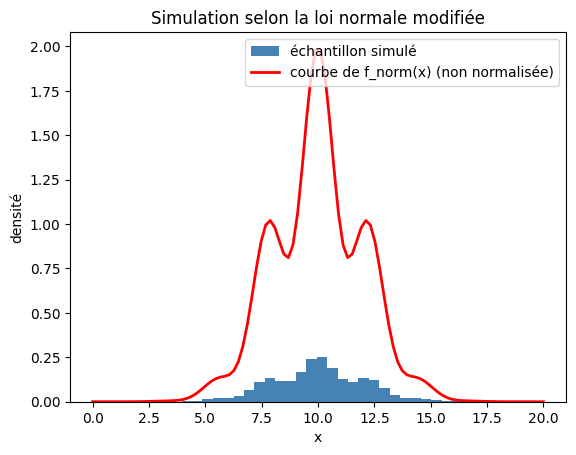

In [4]:
# Définition de paramètres pour vérifier graphiquement 
x0 = 10
b = 20
sigma = 2
delta = 5
M = 2
n = 100000
ech = echantillon_f_norm(x0, b, sigma, delta, n)
x_grid = np.linspace(0, b,100)

plt.hist(ech, bins=40, density=True,color='steelblue', label='échantillon simulé')
plt.plot(x_grid, f_norm(x_grid,x0,b,sigma,delta), 'r', lw=2, label='courbe de f_norm(x) (non normalisée)')
plt.title("Simulation selon la loi normale modifiée")
plt.xlabel("x")
plt.ylabel("densité")
plt.legend()


Cette première méthode nous permet d'obtenir un coût moyen M * b ici M=2 donc C=2*b
Conscients que nous pouvons choisir b grand (et donc avoir un coût élevé), nous décidons en parallèle d'implémenter la deuxième méthode de rejet : par rapport à la loi normale. En effet : la loi normale étant proche de la loi normale 'modifiée' nous pouvons espérer un coût faible car il y aura un meilleur taux d'acceptation.

On a :
$$
f(x)=\mathbf{1}_{[0,b]}(x)\;\exp\!\left(-\dfrac{(x-x_0)^2}{2\sigma^2}\right)\;\bigg(1+\cos^2\!\bigg(\dfrac{2\pi(x-x_0)}{\delta}\bigg)\bigg).
$$

On propose comme densité de référence une loi normale de moyenne $x_0$ et de variance $\sigma^2$ :
$$
g(x)=\dfrac{1}{\sqrt{2\pi}\,\sigma}\,\exp\!\left(-\dfrac{(x-x_0)^2}{2\sigma^2}\right).
$$

En divisant, on obtient :
$$
\frac{f(x)}{g(x)}
= \mathbf{1}_{[0,b]}(x)\,\bigg(1+\cos^2\!\bigg(\dfrac{2\pi(x-x_0)}{\delta}\bigg)\bigg)\times\sqrt{2\pi}\,\sigma.
$$

Or, pour tout réel $t$ on a $\cos^2(t) \le 1$.  

En prenant $t = \dfrac{2\pi(x-x_0)}{\delta}$, on obtient alors :
$$
1+\cos^2\!\bigg(\dfrac{2\pi(x-x_0)}{\delta}\bigg)\le 2.
$$

On en déduit :
$$
\frac{f(x)}{g(x)} \le 2\,\sqrt{2\pi}\,\sigma \equiv M.
$$


In [5]:
def g(x,x0,sigma):
    """ densité d'une loi normale de paramètre (x0,sigma)"""
    return (1 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-((x - x0)**2) / (2 * sigma**2))

def echantillon_f_norm_opt(x0,b,sigma,delta,n):
    
    """ x0 : constante 
    b : constante positive
    sigma : constante positive
    delta : constante positive 
    n : constante taille de l'échantillon

    Simule un échantillon de taille n selon f_norm grâce à la méthode du rejet (version2)"""
    M=2*np.sqrt(2*np.pi)*sigma
    res=[]
    while len(res) < n:
        X = np.random.normal(x0, sigma)   
        Y = np.random.uniform(0, M)
        if Y*g(X,x0,sigma) <= f_norm(X,x0,b,sigma,delta):
            res.append(X) #condition d'acceptation
    return res
    

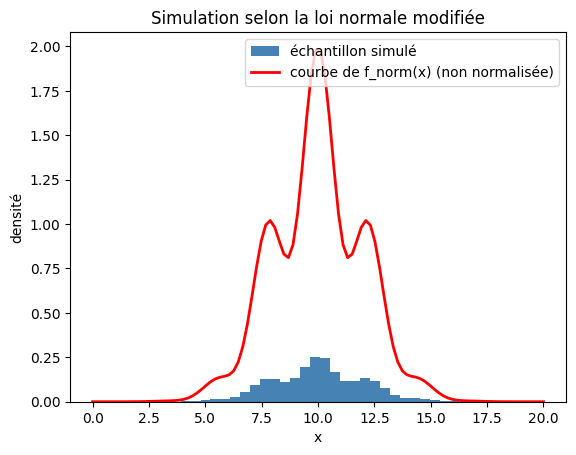

In [6]:
#on reprend les mêmes paramètres que précédemment
ech = echantillon_f_norm_opt(x0, b, sigma, delta, n)
x_grid = np.linspace(0, b,100)

plt.hist(ech, bins=40, density=True,color='steelblue', label='échantillon simulé')
plt.plot(x_grid, f_norm(x_grid,x0,b,sigma,delta), 'r', lw=2, label='courbe de f_norm(x) (non normalisée)')
plt.title("Simulation selon la loi normale modifiée")
plt.xlabel("x")
plt.ylabel("densité")
plt.legend()

###  &nbsp;&nbsp;&nbsp; 2) Simuler selon f_puiss : Méthode d'inversion de la fonction de répartition 

On peut normaliser $f(x)$ en faisant le calcul :

$$
\int_a^{+\infty} C \, x^{-\alpha} \, dx = 1
$$

Or :
$$
\int_a^{+\infty} x^{-\alpha}\, dx = \left[ \frac{x^{-\alpha+1}}{-\alpha+1} \right]_{a}^{+\infty}
$$

Donc :
$$
C \cdot \frac{a^{-\alpha+1}}{\alpha - 1} = 1
$$

Ainsi :
$$
C = \frac{\alpha - 1}{a}
\cdot a^{\alpha - 1}
= (\alpha - 1)\, a^{\alpha - 1}
$$

Donc la densité normalisée est :
$$
f(x) = \mathbf{1}_{[a,+\infty)}(x) \, (\alpha - 1) \, a^{\alpha - 1} \, x^{-\alpha}
$$

---

De là, on peut en déduire la fonction de répartition :

$$
F(x) = \int_a^{x} (\alpha - 1)\, a^{\alpha - 1} \, t^{-\alpha} \, dt
$$

On intègre :

$$
F(x)
= (\alpha - 1)\, a^{\alpha - 1} \left[ \frac{t^{-\alpha + 1}}{-\alpha + 1} \right]_{a}^{x}
$$

$$
F(x)
= 1 - \left( \frac{a}{x} \right)^{\alpha - 1}
$$

---

La fonction de répartition peut alors s'inverser :

On pose :

$$
u = F(x) = 1 - \left( \frac{a}{x} \right)^{\alpha - 1}
$$

Donc :

$$
1 - u = \left( \frac{a}{x} \right)^{\alpha - 1}
$$

$$
\left( 1 - u \right)^{-\frac{1}{\alpha - 1}} = \frac{x}{a}
$$

Ainsi :

$$
F^{-1}(u) = a \, (1 - u)^{-\frac{1}{\alpha - 1}}
$$


In [7]:
def f_puiss(a,alpha,x):
    ind = x>=a
    return ind*(x**(-alpha))
def inverse_fdr_f_puiss(a,alpha,u):
    """ formule d'inversion de la fonction de répartition calculée ci-dessus"""
    return a * (1 - u) ** (-1.0 / (alpha - 1)) #appliquer la fonction inverse 
    
def echantillon_f_puiss(a, alpha,n):
    """ simuler selon la loi f_puiss"""
    u = np.random.rand(n)             # array de n valeurs uniformes dans [0,1]
    return inverse_fdr_f_puiss(a,alpha,u)

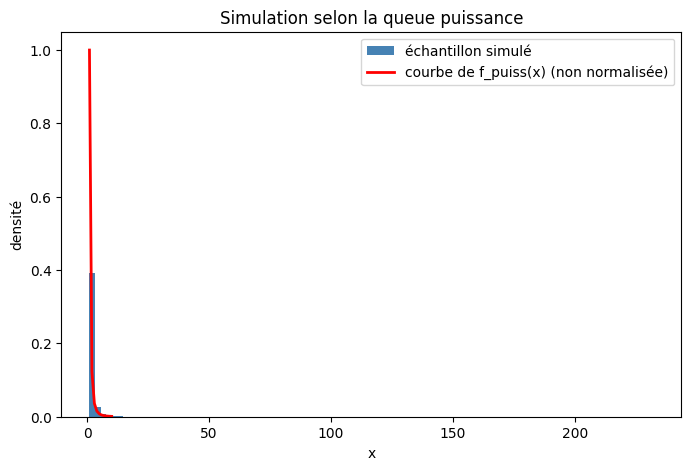

In [8]:
#Définition de paramètres : 
a = 1.0     
alpha = 3 
n = 100000
ech2 = echantillon_f_puiss(a,alpha, n)
plt.figure(figsize=(8,5))
x_grid = np.linspace(a,np.percentile(ech2, 99),10)
plt.hist(ech2, bins=100, density=True,color='steelblue', label='échantillon simulé')
plt.plot(x_grid, f_puiss(a, alpha, x_grid), 'r', lw=2, label='courbe de f_puiss(x) (non normalisée)')
plt.title("Simulation selon la queue puissance")
plt.xlabel("x")
plt.ylabel("densité")
plt.legend()


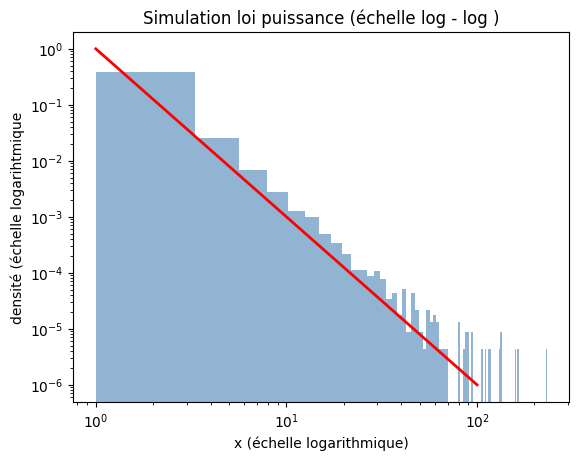

In [9]:

x_grid = np.linspace(a, 100,10)
plt.hist(ech2, bins=100, density=True, color='steelblue', alpha=0.6)
plt.plot(x_grid, f_puiss(a, alpha, x_grid), 'r', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("x (échelle logarithmique)")
plt.ylabel("densité (échelle logarihtmique")
plt.title("Simulation loi puissance (échelle log - log )")
plt.show()

###  &nbsp;&nbsp;&nbsp; 2) Simuler le montant d'un sinistre

In [10]:
def echantillon_X(p, x0, b, sigma, delta, a, alpha, n):
    """
    Simule un échantillon de taille n de la variable aléatoire X
    selon la loi P_sinis définie par :
    - Z ~ P_melange avec P(Z=k) = p_k
    - X = X_norm si Z=0
    - X = X_puiss si Z=1
    - X = Z si Z > 1

    Paramètres :
    p : np array des probabilités (p0, p1, p2, ...)
    x0, b, sigma, delta : paramètres pour f_norm
    a, alpha : paramètres pour f_puiss
    n : taille de l’échantillon
    """
    assert np.all(p >= 0), "Toutes les probabilités doivent être positives."
    assert np.sum(p)== 1.0, "La somme des p_k doit être égale à 1."

    valeurs_Z = np.arange(len(p)) #valeurs possibles de Z : selon taille de p (qui correspond à p_k dans l'énoncé)
    X = []

    for _ in range(n):
        Z = np.random.choice(valeurs_Z, p=p) #on tire une valeur de Z selon les probas p_k
        if Z == 0:
            X.append(echantillon_f_norm_opt(x0, b, sigma, delta, 1)[0])
        elif Z == 1:
            X.append(echantillon_f_puiss(a, alpha, 1)[0])
        else:
            X.append(Z)

    return np.array(X)

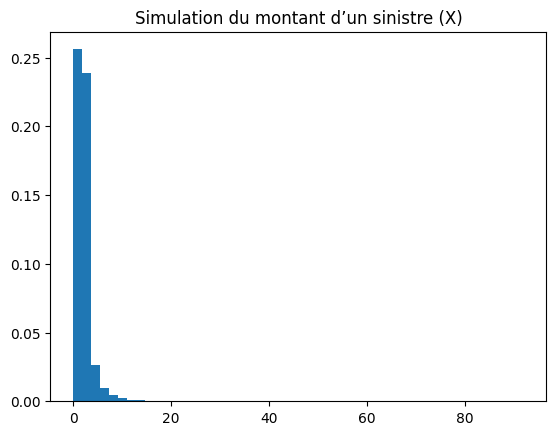

In [11]:
# Exemple
p = np.array([0.5, 0.3, 0.2])
x0, b, sigma, delta = 1.0, 5.0, 0.5, 1.0
a, alpha = 2.0, 3.0

ech = echantillon_X(p, x0, b, sigma, delta, a, alpha, n=10000)

import matplotlib.pyplot as plt
plt.hist(ech, bins=50, density=True)
plt.title("Simulation du montant d’un sinistre (X)")
plt.show()


Ainsi, on peut remarquer que l'on a une forme à laquelle on pouvait s'attendre : Z=0 désigne ici les 'petits' sinistres avec globalement des petites pertes : loi normale, Z=1 représente des sinistres plus lourds avec une perte plus conséquente. Et Z>1 des cas extrêmes. Dans notre cas, on a une chance sur deux d'avoir des petits sinistres d'où la concentration dans des valeurs faibles ainsi que les extrêmes car ici z prend des valeurs faibles. Même si on peut apercevoir la queue de distribution. Changeons la proba des petits sinistres et des valeurs extrêmes (en les diminuant) pour voir l'évolution.

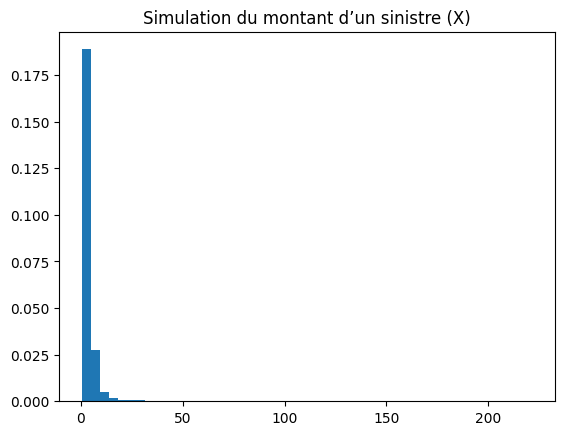

In [12]:
# Exemple
p = np.array([0.001, 0.998, 0.001])
x0, b, sigma, delta = 1.0, 5.0, 0.5, 1.0
a, alpha = 2.0, 3.0

ech = echantillon_X(p, x0, b, sigma, delta, a, alpha, n=10000)

import matplotlib.pyplot as plt
plt.hist(ech, bins=50, density=True)
plt.title("Simulation du montant d’un sinistre (X)")
plt.show()


Ainsi, on observe que la concentration vers des valeurs faibles de montant de sinistres est moins forte. De même le montant maximal de sinistre est plus fort dans ce cas ci.

On pourrait aussi penser à simuler Z avec une méthode de rejet. Nous allons l'implémenter puis nous comparerons leur efficacité respective.

In [13]:
def echantillon_Z_rejet(p, n):
    """
    Simule un échantillon de taille n de la variable discrète Z
    dont la loi est P(Z=k)=p_k, en utilisant la méthode du rejet.

    Paramètres :
    p : np array
        Probabilités (p0, p1, ..., pk) telles que sum(p)=1
    n : Taille de l'échantillon à générer

    """
    k = len(p) # valeurs de z maximale
    M = np.max(p)  
    res = []

    while len(res) < n:
        # I ← générateur uniforme sur {0, ..., k-1}
        I = np.random.randint(0, k)
        # U ← générateur uniforme sur [0, M[
        U = np.random.uniform(0, M)

        # Test d'acceptation
        if U <= p[I]:
            res.append(I)

    return np.array(res)

In [14]:
def echantillon_X_rejet(p, x0, b, sigma, delta, a, alpha, n):
    """
    Simule un échantillon de taille n de la variable aléatoire X selon :
        X = X_norm  si Z = 0
        X = X_puiss si Z = 1
        X = Z       si Z > 1
    avec Z simulé par la méthode du rejet.

    Paramètres: 
    cf echantillon_X 
    """

    # Simuler Z avec la méthode du rejet
    Z = echantillon_Z_rejet(p, n)
    X = []

    
    for z in Z:
        # Génération d'une valeur de X selon valeur de z
        if z == 0:
            X.append(echantillon_f_norm_opt(x0, b, sigma, delta, 1)[0])
        elif z == 1:
            X.append(echantillon_f_puiss(a, alpha, 1)[0])
        else:
            X.append(z)

    return np.array(X)

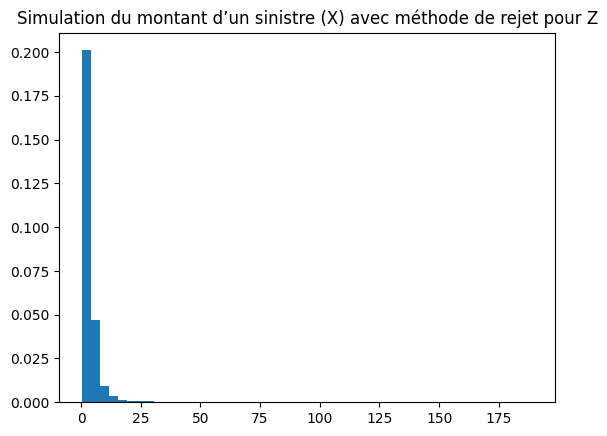

In [15]:
# Exemple
p = np.array([0.001, 0.998, 0.001])
x0, b, sigma, delta = 1.0, 5.0, 0.5, 1.0
a, alpha = 2.0, 3.0

ech = echantillon_X_rejet(p, x0, b, sigma, delta, a, alpha, n=10000)

import matplotlib.pyplot as plt
plt.hist(ech, bins=50, density=True)
plt.title("Simulation du montant d’un sinistre (X) avec méthode de rejet pour Z")
plt.show()


## II) Simulation de la météo

In [16]:
def simuler_chaine_markov(M, H0, N):
    """
    Simule une chaîne de Markov (H_i) sur N jours à partir d'un état initial H0.

    Paramètres : 
    M : np.array de taille 3*3, Matrice de transition
    H0 : int, État initial (dans {1, 2,3})
    N : int, Nombre d'étapes (jours) à simuler

   
    """

    # --- Programmation défensive ---
    d1, d2 = M.shape
    assert d1 == d2, "M doit être une matrice carrée"
    assert 1 <= H0 <= 3, f"H0 doit être dans {{1,...,{d1}}}"

    # Initialisation de la trajectoire
    H = []
    H.append(H0)

    # Simulation selon l'algorithme
    for i in range(1, N + 1):
        ligne = M[H[i - 1] - 1]             # loi conditionnelle selon l'état précédent
        H.append(np.random.choice(np.arange(1,4), p=ligne)) #on choisit l'état entre 1 et 3 avec les probas de la ligne correspondante

    return np.array(H)


In [17]:
M = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.2, 0.3, 0.5]
])

H0 = 1    # Beau temps le premier jour
N = 30    # Simuler 30 jours

H = simuler_chaine_markov(M, H0, N)
print("Chaîne simulée :", H)


Chaîne simulée : [1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 3 2 1 2 3 2 1 2 2 3]


Là encore, on pourrait penser à une méthode de programmation permettant de réduire potentiellement la complexité :  introduire une table de Walker.

## III) Simulation des occurences de sinistres

In [18]:
def simuler_processus_poisson(lambd, horizon=1.0):
    """
    Simule un processus de Poisson homogène sur [0, horizon]
    Renvoie la liste des temps d'occurences T_n
    """
    T = []
    tn = 0
    
    while True:
        tn += np.random.exponential(1/lambd)
        if tn > horizon:
            break
        T.append(tn)
    
    return np.array(T)


In [19]:
def simuler_sinistres_avec_temps(H, lambd, p, x0, b, sigma, delta, a, alpha):
    """
    Renvoie une liste de tuples : (T_i : temps occurence, X_i : montant sinistre associé)
    """

    liste_T_X = []  # liste des couples (temps, montant)

    for jour in range (len(H)):
        etat = H[jour] #on récupère la météo du jour
        lambda_j = lambd[etat - 1] # lambda associé à cette météo

        temps = simuler_processus_poisson(lambda_j) #temps correspondant aux occurences des sinistres ce jour là 
#les sinistres conditionnellement à la météo suivent un processus de Poisson homogène
    
        montants = echantillon_X_rejet(p, x0, b, sigma, delta, a, alpha, len(temps)) # Simuler un montant pour chauqe temps
        for i in range (len(temps)):
            t=temps[i]
            liste_T_X.append((jour + t, montants[i]))

    return liste_T_X


## IV) Théorie de la ruine

###  &nbsp;&nbsp;&nbsp; 1) Modèle A : Météo commune

Dans ce modèle on simule une seule chaîne de Markov valable pour tous les assurés. Nos assurés sont donc corrélés par la météo.

In [20]:
def modele_A_meteo_commune(N_assures, u, c, horizon, 
                            M, H0, lambd, 
                            p, x0, b, sigma, delta, a, alpha):
    """
    Paramètres :
    N_assures : int — nombre d’assurés
    u : float — investissement initial par assuré
    c : float — taux de prime par assuré et par unité de temps
    horizon : int — durée de la simulation (en jours ou années selon ton unité)
    M : np.array — matrice de transition 3x3 de la météo
    H0 : int — état initial (1, 2 ou 3)
    lambd : array — intensités de sinistres par état météo (taille 3)
    p, x0, b, sigma, delta, a, alpha : paramètres des lois de sinistres (cf code avant)
    
    Retour :
    Rt : np.array — valeurs du processus R_t juste après chaque sinistre
    t_ruine : float ou None — temps du premier passage de R_t sous 0
    T_global : np.array : occurences des sinistres 
    """
    H = simuler_chaine_markov(M, H0, horizon)  #simulation de la chaîne de Markov météo (commune à tous)

    T_all = []
    X_all = []
    for i in range(N_assures):
        sinistres_i = simuler_sinistres_avec_temps(H, lambd, p, x0, b, sigma, delta, a, alpha)
        if len(sinistres_i) > 0:
            T_i = np.array([t for (t, x) in sinistres_i])
            X_i = np.array([x for (t, x) in sinistres_i])
            T_all.append(T_i)
            X_all.append(X_i)

    # S'il n'y a aucun sinistre chez tous les assurés
    if len(T_all) == 0:
        return np.array([]), np.array([]), None

    # On fusionne tous les sinistres dans une seule chronologie
    T_global = np.concatenate(T_all)
    X_global = np.concatenate(X_all)
    indices_tri = np.argsort(T_global) #retourne une permutation d'indices pour avoir les temps triés par ordre croissant

    T_global = T_global[indices_tri]
    X_global = X_global[indices_tri]

    # Calcul du processus de réserve agrégée
    Rt = N_assures * u + N_assures * c * T_global - np.cumsum(X_global)

       # Détection de la ruine
    indices_ruine = np.where(Rt < 0)[0] #récupérer les indices où on passe à des valeurs négatives -> np.where permet d'avoir un tuple (indices,valeurs) où la condition est vraie
    t_ruine = None
    if len(indices_ruine) > 0:
        t_ruine = T_global[indices_ruine[0]]#seulement si on a un instant de ruine sinon None -> seul le premier instant où on passe le seuil de 0 nous intéresse

    return T_global, Rt, t_ruine


Nombre de sinistres simulés : 3
Temps de ruine (None si pas de ruine) : None


Text(0, 0.5, 'Réserve R_t')

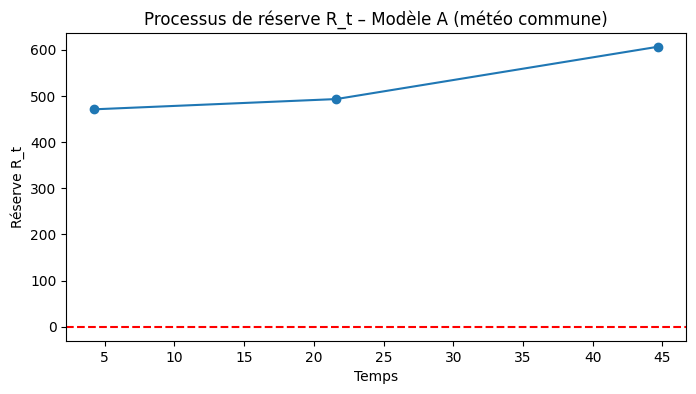

In [21]:
# --- Paramètres du modèle A ---
N = 5
u = 100
c = 1
horizon = 50  # jours

# Matrice météo
M = np.array([
    [0.8, 0.15, 0.05],
    [0.1, 0.8,  0.1 ],
    [0.05, 0.15, 0.8 ]
])
H0 = 1
lambd = np.array([0.02, 0.02, 0.02])

# Paramètres sinistres
p = np.array([0.7, 0.25, 0.05])
x0 = 50
b = 500
sigma = 20
delta = 30
a = 100
alpha = 2.5

# --- Simulation ---
T, Rt, t_ruine = modele_A_meteo_commune(N, u, c, horizon, M, H0, lambd, p, x0, b, sigma, delta, a, alpha)

print(f"Nombre de sinistres simulés : {len(T)}")
print(f"Temps de ruine (None si pas de ruine) : {t_ruine}")

# --- Optionnel : visualisation ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(T, Rt, '-o')
plt.axhline(0, color='r', linestyle='--')
plt.title("Processus de réserve R_t – Modèle A (météo commune)")
plt.xlabel("Temps")
plt.ylabel("Réserve R_t")


Avec ces paramètres là, on peut vérifier que le nombre de sinistres calculé est pertinent, en effet les valeurs lambdas sont faibles ≈ 0,02 par jour dans le meilleur cas, soit 1 sinistre tous les 50 jours en moyenne par assuré. Ici on a 5 assurés et un horizon 50 jours donc cela paraît pertinent d'avoir de l'ordre de 0 à 10 sinistres simulés.
Ainsi la simulation des processus de Poisson semble pertinente. Maintenant,notre objectif est de simuler plus de sinistres et donc de potentiellement voir un instant de ruine. Pour cela on augmente les fréquences de sinistre : les lambdas, augmenter l'horizon, réduire les primes / capital initial pour observer un phénomène de ruine plus rapide. De même, on peut augmenter le nombre d'assurés et voir les impacts.

Nombre de sinistres simulés : 269
Temps de ruine (None si pas de ruine) : 15.538778120048502


Text(0, 0.5, 'Réserve R_t')

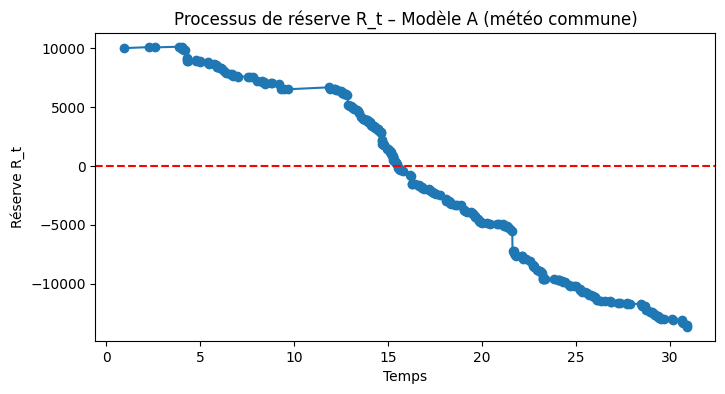

In [27]:
# --- Paramètres du modèle A ---
N = 100
u = 100
c = 1
horizon = 30  # jours (par ex.)

# Matrice météo
M = np.array([
    [0.8, 0.15, 0.05],
    [0.1, 0.8,  0.1 ],
    [0.05, 0.15, 0.8 ]
])
H0 = 1
lambd = np.array([0.02, 0.08, 0.2])

# Paramètres sinistres
p = np.array([0.7, 0.25, 0.05])
x0 = 50
b = 500
sigma = 20
delta = 30
a = 100
alpha = 2.5

# --- Simulation ---
T, Rt, t_ruine = modele_A_meteo_commune(N, u, c, horizon, M, H0, lambd, p, x0, b, sigma, delta, a, alpha)

print(f"Nombre de sinistres simulés : {len(T)}")
print(f"Temps de ruine (None si pas de ruine) : {t_ruine}")

# --- Optionnel : visualisation ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(T, Rt, '-o')
plt.axhline(0, color='r', linestyle='--')
plt.title("Processus de réserve R_t – Modèle A (météo commune)")
plt.xlabel("Temps")
plt.ylabel("Réserve R_t")


In [57]:
def modele_B_meteo_indep(N_assures, u, c, horizon, 
                         M, H0, lambd, 
                         p, x0, b, sigma, delta, a, alpha):
    """
    Modèle B : chaque assuré a sa propre chaîne de Markov météo indépendante.

    Paramètres :
    N_assures : int — nombre d’assurés
    u : float — investissement initial par assuré
    c : float — taux de prime par assuré et par unité de temps
    horizon : int — durée de la simulation (en jours, années, etc.)
    M : np.array — matrice de transition 3x3 de la météo
    H0 : int — état météo initial (1, 2 ou 3)
    lambd : array — intensités de sinistres par état météo (taille 3)
    p, x0, b, sigma, delta, a, alpha : paramètres des lois de sinistres

    Retour :
    T_global : np.array — instants de tous les sinistres agrégés
    Rt : np.array — valeurs du processus de réserve après chaque sinistre
    t_ruine : float ou None — temps du premier passage sous 0 (ruine)
    """

    T_all = []
    X_all = []

    for i in range(N_assures):
        # Chaque assuré a sa propre météo
        H_i = simuler_chaine_markov(M, H0, horizon)

        # Simulation des sinistres pour cet assuré (comme auparavant)
        sinistres_i = simuler_sinistres_avec_temps(H_i, lambd, p, x0, b, sigma, delta, a, alpha)
        if len(sinistres_i) > 0:
            T_i = np.array([t for (t, x) in sinistres_i])
            X_i = np.array([x for (t, x) in sinistres_i])
            T_all.append(T_i)
            X_all.append(X_i)

    # Si aucun sinistre n’a eu lieu chez tous les assurés
    if len(T_all) == 0:
        return np.array([]), np.array([]), None

    # Fusion de tous les sinistres + tri par ordre croissant
    T_global = np.concatenate(T_all)
    X_global = np.concatenate(X_all)
    indices_tri = np.argsort(T_global)
    T_global = T_global[indices_tri]
    X_global = X_global[indices_tri]

    # processus dé réserve
    Rt = N_assures * u + N_assures * c * T_global - np.cumsum(X_global)

    # détecter instant de ruine
    indices_ruine = np.where(Rt < 0)[0]
    t_ruine = None
    if len(indices_ruine) > 0:
        t_ruine = T_global[indices_ruine[0]]

    return T_global, Rt, t_ruine


Nombre de sinistres simulés : 186
Temps de ruine (None si pas de ruine) : 27.347423002312016


Text(0, 0.5, 'Réserve R_t')

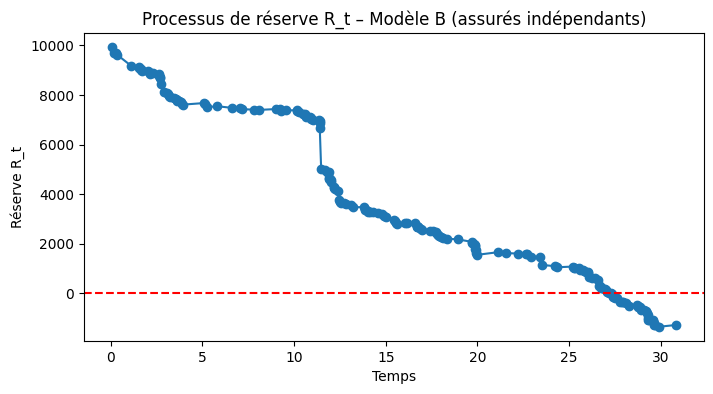

In [59]:
# --- Paramètres du modèle B --- Idem au modèle A mais avec B voir la comparaison
N = 100
u = 100
c = 1
horizon = 30  # jours (par ex.)

# Matrice météo
M = np.array([
    [0.8, 0.15, 0.05],
    [0.1, 0.8,  0.1 ],
    [0.05, 0.15, 0.8 ]
])
H0 = 1
lambd = np.array([0.02, 0.08, 0.2])

# Paramètres sinistres
p = np.array([0.7, 0.25, 0.05])
x0 = 50
b = 500
sigma = 20
delta = 30
a = 100
alpha = 2.5

# --- Simulation ---
T, Rt, t_ruine = modele_A_meteo_commune(N, u, c, horizon, M, H0, lambd, p, x0, b, sigma, delta, a, alpha)

print(f"Nombre de sinistres simulés : {len(T)}")
print(f"Temps de ruine (None si pas de ruine) : {t_ruine}")

# --- Optionnel : visualisation ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(T, Rt, '-o')
plt.axhline(0, color='r', linestyle='--')
plt.title("Processus de réserve R_t – Modèle B (assurés indépendants)")
plt.xlabel("Temps")
plt.ylabel("Réserve R_t")


## V) Résultat attendu 

In [61]:
def estimation_probabilite_ruine(modele, N_simulations, 
                                 N_assures, u, c, horizon,
                                 M, H0, lambd,
                                 p, x0, b, sigma, delta, a, alpha):

    nb_ruines = 0

    for _ in range(N_simulations):
        _, _, t_ruine = modele(N_assures, u, c, horizon,
                               M, H0, lambd,
                               p, x0, b, sigma, delta, a, alpha)

        if t_ruine is not None:
            nb_ruines += 1

    return nb_ruines / N_simulations


In [71]:
N = 10
u = 100
c = 3000
horizon = 30  # jours (par ex.)

# Matrice météo
M = np.array([
    [0.8, 0.15, 0.05],
    [0.1, 0.8,  0.1 ],
    [0.05, 0.15, 0.8 ]
])
H0 = 1
lambd = np.array([0.02, 0.08, 0.2])

# Paramètres sinistres
p = np.array([0.7, 0.25, 0.05])
x0 = 50
b = 500
sigma = 20
delta = 30
a = 100
alpha = 2.5   

prob_A = estimation_probabilite_ruine(modele_A_meteo_commune,
                                      50,   
                                      N_assures, u, c, horizon,
                                      M, H0, lambd,
                                      p, x0, b, sigma, delta, a, alpha)

prob_B = estimation_probabilite_ruine(modele_B_meteo_indep,
                                      50,
                                      N_assures, u, c, horizon,
                                      M, H0, lambd,
                                      p, x0, b, sigma, delta, a, alpha)

print("Probabilité de ruine - météo commune :", prob_A)
print("Probabilité de ruine - météo indépendante :", prob_B)



Probabilité de ruine - météo commune : 0.0
Probabilité de ruine - météo indépendante : 0.0
